In [1]:
import ROOT
import ROOT.ROOT as rr

import uproot
import numpy as np
import pandas as pd
import os
from pathlib import Path
import awkward as ak

import random

import FilterFunctions as ff
import cpp

Welcome to JupyROOT 6.24/00


### Implementation of the skimming step of the analysis

The skimming step reduces the inital generic samples to a dataset optimized for this specific analysis. Most important, the skimming removes all events from the initial dataset, which are not of interest for our study.

In [2]:
dirBasePath  = '/data/FCNC/'
dirOutPath = '/data/Skim/'
dirPlotPath = './Plots/'

listDir = os.listdir(dirBasePath)

In [3]:
def returnDir(string):
    return [filename for filename in listDir if filename.startswith(string)]

def loadData(chain, pathDirs, info=False):
    # Set up multi-threading capability of ROOT
    rr.EnableImplicitMT()
    
    for Dir in pathDirs:
        if info: print('>>> Process directory ', Dir)
        file_list = os.listdir(dirBasePath + Dir)
        for file in file_list:
            chain.AddFile(dirBasePath + Dir + '/' + file)
            
    return chain

def CountEvents(df, info=True):
    n = df.Count().GetValue()
    if info: print('\nNumber of events:', n, '\n')
    return n

# Retrieve a histogram from the input file based on the process and the variable name
def getHistogram(tfile, name, variable, tag=''):
    name = '{}_{}{}'.format(name, variable, tag)
    h = tfile.Get(name)
    if not h:
        raise Exception('Failed to load histogram {}.'.format(name))
    return h

#### List of all MC background directories

'DYJetsToLL_M', 'QCD', 'ST_s', 'ST_t', 'ST_tW_antitop', 'ST_tW_top', 'TTTT_Tune', 'TTTo2L2Nu', 'TTToHadronic',
'TTToSemiLeptonic', 'TTWJetsToLNu', 'TTZToLLNuNu', 'WGToLNuG', 'WJetsToLNu', 'WWTo2L2Nu', 'WWW', 'WWZ', 'WZG',
'WZTo1L1Nu2Q', 'WZTo2L2Q', 'WZTo3LNu', 'WZZ', 'WmWmJJ', 'WminusH', 'WpWpJJ', 'ZG', 'ZZ', 'tZq'

In [4]:
# - Data + MC Signal
signalDirs = returnDir('SingleMuon')
signalMCDirs = returnDir('TT_FCNC')

# - MC backgrounds
listBkgDir = ['ST_', 'TTTT_Tune', 'TTTo2L2Nu', 'TTToHadronic', 'TTToSemiLeptonic', 'TTWJetsToLNu', 'TTZToLLNuNu',
              'WGToLNuG', 'WJetsToLNu', 'WWTo2L2Nu', 'WWW', 'WWZ', 'WZG', 'WZTo1L1Nu2Q', 'WZTo2L2Q', 'WZTo3LNu',
              'WZZ', 'WmWmJJ', 'WminusH', 'WpWpJJ', 'ZG', 'ZZ', 'tZq', 'DYJetsToLL_M', 'QCD']

bkgMCDirs = dict(list(zip(listBkgDir, map(returnDir, listBkgDir))))
bkgMCChain = dict(list(zip(listBkgDir, [ROOT.TChain('Events') for _ in range(len(listBkgDir))])))

In [5]:
# - Load Data + MC Signal

chainSig = ROOT.TChain('Events')
dfData = rr.RDataFrame(loadData(chainSig, signalDirs))
# CountEvents(dfData)

chainMC = ROOT.TChain('Events')
dfMCSig = rr.RDataFrame(loadData(chainMC, signalMCDirs))
# CountEvents(dfMCSig)

In [6]:
# - Load MC backgrounds

dfMCBkg = {}
for key, value in bkgMCDirs.items():
    dfMCBkg[key] = rr.RDataFrame(loadData(bkgMCChain[key], value))
#     CountEvents(dfMCBkg[key])

In [ ]:
def signif(nSkim, title):
    fSig = ff.DeclareVariables[nSkim](dfMCSig, '', save=False)
    numData = CountEvents(fSig, info=False)
    
    numMC = 0
    for key, value in dfMCBkg.items():
        fMC = ff.DeclareVariables[nSkim](value, '', save=False)
        numMC += CountEvents(fMC, info=False)
    
    significance = round(numData/np.sqrt(numMC),3)
    with open('signif.txt', 'a') as f:
        f.write('\niSkim' + str(nSkim) + '\t' + title + '\t' + str(significance))
        f.close()

In [ ]:
signif(3, 'Jet_btagDeepB > 0.1')

### Read skimmed file

In [ ]:
%%bash

rm /data/Skim/*.root

In [ ]:
%%bash

ls /data/Skim

In [ ]:
for i in range(1,5):
    ff.DeclareVariables[i](dfData, 'Data', save=True)

In [ ]:
%%bash

ls /data/FCNC/TT_FCNC*

In [ ]:
# file = uproot.open(dirOutPath + 'DataFlat4.root')
file = uproot.open('/data/FCNC/TT_FCNC-aTtoHJ_Tleptonic_HToWWZZtautau_eta_hct_TuneCP5-MadGraph5-pythia8_RunIIAutumn18/01CCCFF0-DAD1-BC40-936E-86309FDAA709_Skim.root')
tree = file['Events']
# tree.keys()
df = tree.arrays(['eventWeightLumi', 'Muon_charge', 'Muon_jetIdx', 'iSkim'], library='pd')
df[df.Muon_jetIdx == -1].head(20)
# len(df)

In [ ]:
import matplotlib.pyplot as plt

# plt.hist(df.inv_m01, bins=100)
plt.hist(df.inv_m01, bins=50, histtype='step')
# plt.vlines(90, 0, 300, color='red')
plt.show()

### Histograms: save in `.root` extension

In [7]:
ROOT.gROOT.SetBatch(True)

################################################################################
# Declare the range of the histogram for each variable
#
# Each entry in the dictionary contains of the variable name as key and a tuple
# specifying the histogram layout as value. The tuple sets the number of bins,
# the lower edge and the upper edge of the histogram.
################################################################################

# set w2 for MC errors - actually look for Sumw2() i.e. sum of weights squared!

# Book a histogram for a specific variable
#def bookHistogram(df, variable, range_):
#    return df.Histo1D(rr.RDF.TH1DModel(variable, variable, range_[0], range_[1], range_[2]), variable, 'eventWeightLumi')

def bookHistogram(df, variable, range_):
    histo = ROOT.TH1D()
    histo.Sumw2()
    histo = df.Histo1D(rr.RDF.TH1DModel(variable, variable, range_[0], range_[1], range_[2]), variable, 'eventWeightLumi')
    return histo

# Write a histogram with a given name to the output ROOT file
def writeHistogram(h, name):
    h.SetName(name)
    h.Write()

################################################################################
# Main function of the histogramming step
#
# The function loops over the outputs from the skimming step and produces the
# required histograms for the final plotting.
################################################################################

def main(nSkim):
    # Set up multi-threading capability of ROOT
    rr.EnableImplicitMT()
    ranges = ff.SkimRanges[nSkim]
    
    # Create output file
    tfile = ROOT.TFile(dirPlotPath + 'Trials/8_{}.root'.format(nSkim), 'RECREATE')
    variables = ranges.keys()
    
    fdfData = ff.DeclareVariables[nSkim](dfData, '', save=False)
    fdfMCSig = ff.DeclareVariables[nSkim](dfMCSig, '', save=False)
    
    # Loop through skimmed datasets and produce histograms of variables
    hists = {}
    for variable in variables:
        hists[variable] = bookHistogram(fdfData, variable, ranges[variable])

    hists_sig_mc = {}
    for variable in variables:
        hists_sig_mc[variable] = bookHistogram(fdfMCSig, variable, ranges[variable])

    # Write histograms to output file
    for variable in variables:
        writeHistogram(hists[variable], '{}_{}'.format('Data', variable))
    for variable in variables:
        writeHistogram(hists_sig_mc[variable], '{}_{}'.format('MCSig', variable))
        
    
    for key, value in dfMCBkg.items():
        fdfMCBkg = ff.DeclareVariables[nSkim](value, '', save=False)
        
        hists = {}
        for variable in variables:
            hists[variable] = bookHistogram(fdfMCBkg, variable, ranges[variable])
        for variable in variables:
            writeHistogram(hists[variable], '{}_{}'.format(key, variable))
    
    tfile.Close()

if __name__ == '__main__':
    main(3)

### Final plotting

In [8]:
################################################################################
# Implementation of the plotting step of the analysis
################################################################################

# Declare a human-readable label for each variable
nSkim = 3
labels = ff.SkimLabels[nSkim]
    
# Specify the color for each process:
# - Signal
colors = {
        'Data': ROOT.TColor.GetColor('#BF2229'),
        'MCSig': ROOT.TColor.GetColor('#00A88F'),
        }
# - MC BKG
colorsBkg = {
    'ST_': ROOT.TColor.GetColor(222, 90, 106),
    'TTTT_Tune': ROOT.TColor.GetColor(248, 206, 104),
    'TTTo2L2Nu': ROOT.TColor.GetColor(248, 206, 104),
    'TTToHadronic': ROOT.TColor.GetColor(248, 206, 104),
    'TTToSemiLeptonic': ROOT.TColor.GetColor(248, 206, 104),
    'TTWJetsToLNu': ROOT.TColor.GetColor(155, 152, 204),
    'TTZToLLNuNu': ROOT.TColor.GetColor(247, 138, 221),
    'WGToLNuG': ROOT.TColor.GetColor(250, 202, 255),
    'WJetsToLNu': ROOT.TColor.GetColor(250, 202, 255),
    'WWTo2L2Nu': ROOT.TColor.GetColor(250, 202, 255),
    'WWW': ROOT.TColor.GetColor(250, 202, 255),
    'WWZ': ROOT.TColor.GetColor(250, 202, 255),
    'WZG': ROOT.TColor.GetColor(250, 202, 255),
    'WZTo1L1Nu2Q': ROOT.TColor.GetColor(250, 202, 255),
    'WZTo2L2Q': ROOT.TColor.GetColor(250, 202, 255),
    'WZTo3LNu': ROOT.TColor.GetColor(250, 202, 255),
    'WZZ': ROOT.TColor.GetColor(250, 202, 255),
    'WmWmJJ': ROOT.TColor.GetColor(250, 202, 255),
    'WminusH': ROOT.TColor.GetColor(250, 202, 255),
    'WpWpJJ': ROOT.TColor.GetColor(250, 202, 255),
    'ZG': ROOT.TColor.GetColor(250, 202, 255),
    'ZZ': ROOT.TColor.GetColor(250, 202, 255),
    'tZq': ROOT.TColor.GetColor(100, 192, 232),
    'DYJetsToLL_M': ROOT.TColor.GetColor(100, 192, 232),
    'QCD': ROOT.TColor.GetColor(60, 160, 232),
}

################################################################################

scales = {}
# Main function of the plotting step
def main(variable, nSkim, scale=scales):    
    tfile = ROOT.TFile(dirPlotPath + 'Trials/8_{}.root'.format(nSkim), 'READ')

    # Styles
    ROOT.gStyle.SetOptStat(0)

    ROOT.gStyle.SetCanvasBorderMode(0)
    ROOT.gStyle.SetCanvasColor(ROOT.kWhite)
    ROOT.gStyle.SetCanvasDefH(600)
    ROOT.gStyle.SetCanvasDefW(600)
    ROOT.gStyle.SetCanvasDefX(0)
    ROOT.gStyle.SetCanvasDefY(0)

    ROOT.gStyle.SetPadTopMargin(0.08)
    ROOT.gStyle.SetPadBottomMargin(0.13)
    ROOT.gStyle.SetPadLeftMargin(0.16)
    ROOT.gStyle.SetPadRightMargin(0.05)

    ROOT.gStyle.SetHistLineColor(1)
    ROOT.gStyle.SetHistLineStyle(0)
    ROOT.gStyle.SetHistLineWidth(1)
    ROOT.gStyle.SetEndErrorSize(2)
    ROOT.gStyle.SetMarkerStyle(20)

    ROOT.gStyle.SetOptTitle(0)
    ROOT.gStyle.SetTitleFont(42)
    ROOT.gStyle.SetTitleColor(1)
    ROOT.gStyle.SetTitleTextColor(1)
    ROOT.gStyle.SetTitleFillColor(10)
    ROOT.gStyle.SetTitleFontSize(0.05)

    ROOT.gStyle.SetTitleColor(1, 'XYZ')
    ROOT.gStyle.SetTitleFont(42, 'XYZ')
    ROOT.gStyle.SetTitleSize(0.05, 'XYZ')
    ROOT.gStyle.SetTitleXOffset(1.00)
    ROOT.gStyle.SetTitleYOffset(1.60)

    ROOT.gStyle.SetLabelColor(1, 'XYZ')
    ROOT.gStyle.SetLabelFont(42, 'XYZ')
    ROOT.gStyle.SetLabelOffset(0.007, 'XYZ')
    ROOT.gStyle.SetLabelSize(0.04, 'XYZ')

    ROOT.gStyle.SetAxisColor(1, 'XYZ')
    ROOT.gStyle.SetStripDecimals(True)
    ROOT.gStyle.SetTickLength(0.03, 'XYZ')
    ROOT.gStyle.SetNdivisions(510, 'XYZ')
    ROOT.gStyle.SetPadTickX(1)
    ROOT.gStyle.SetPadTickY(1)

    ROOT.gStyle.SetPaperSize(20., 20.)
    ROOT.gStyle.SetHatchesLineWidth(5)
    ROOT.gStyle.SetHatchesSpacing(0.05)

    ROOT.TGaxis.SetExponentOffset(-0.08, 0.01, 'Y')
    
    legend = ROOT.TLegend(0.6, 0.6, 0.9, 0.8)
    legend.SetNColumns(2)

    # Data + MC
    data = getHistogram(tfile, 'Data', variable)
    MCSig = getHistogram(tfile, 'MCSig', variable)
    
    stack = ROOT.THStack('', '')
    bkgError = ROOT.TH1D()
    seen, count, count2, areaBkg = [], 0, 0, 0
    titles = ['Single top', 'top', 'tt#rightarrowW', 'tt#rightarrowZ','Diboson', 'Others', 'qcd']
    for key, value in colorsBkg.items():
        histo = getHistogram(tfile, key, variable)
        histo.SetLineWidth(0)
        histo.SetFillColor(value)
        areaBkg += histo.Integral('width')
        stack.Add(histo)
        #if count2 == 0:
        #    bkgError = histo
        #    count2 += 1
        #else:
        #    bkgError.Sumw2()
        #    bkgError.Add(histo)
        if value not in seen:
            legend.AddEntry(histo, titles[count], 'f')
            count += 1
            seen.append(value)
            
    #legend.AddEntry(bkgError, 'BKG uncertainty', 'f')
        
    areaSig = MCSig.Integral('width')
    scale_MCSig = areaBkg/areaSig
    scales[variable] = scale_MCSig

    # Draw histograms
    data.SetMarkerStyle(20)
    data.SetLineColor(ROOT.kBlack)
    data.SetLineWidth(3)
    MCSig.SetLineColor(colors['MCSig'])
    MCSig.SetLineWidth(3)
    
    MCSig.Scale(scales['Muon_pt15'])

    c = ROOT.TCanvas('', '', 600, 600)
    
    name = data.GetTitle()
    if name in labels:
        title = labels[name]
    else:
        title = name

    stack.Draw('hist')
    MCSig.Draw('HIST SAME')
    data.Draw('E1P SAME')
    #bkgError.Draw('E same')
    
    stack.GetXaxis().SetTitle(labels[variable])
    stack.GetYaxis().SetTitle('N_{Events}')
    stack.SetMaximum(max(stack.GetMaximum(), data.GetMaximum()) * 1.2)
    stack.SetMinimum(1.0)

    # Add legend
    legend.AddEntry(MCSig, 'MCSig', 'f')
    legend.AddEntry(data, 'Data', 'lep')
    legend.SetBorderSize(0)
    legend.Draw()

    # Add title
    latex = ROOT.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextFont(42)
    latex.DrawLatex(0.16, 0.935, '#bf{CMS FCNC}')

    # Save
#     c.SaveAs(dirPlotPath + '{}_{}'.format(variable, nSkim))
    c.SaveAs(dirPlotPath + 'Trials/{}_8_{}.png'.format(variable, nSkim))

# Loop over all variable names and make a plot for each
if __name__ == '__main__':
    for variable in labels.keys():
        main(variable, nSkim)

Info in <TCanvas::Print>: png file ./Plots/Trials/Muon_pt15_8_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/mu_pt0_8_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/inv_m01_8_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/inv_m12_8_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/inv_m02_8_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/inv_m3_8_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/ST_8_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/Jet_pt0_8_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/bJet_pt0_8_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/MET_pt_8_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/dPhi0_8_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/dPhi1_8_3.png has been created
Info in <TCan

Jet_pt0_8_3.png



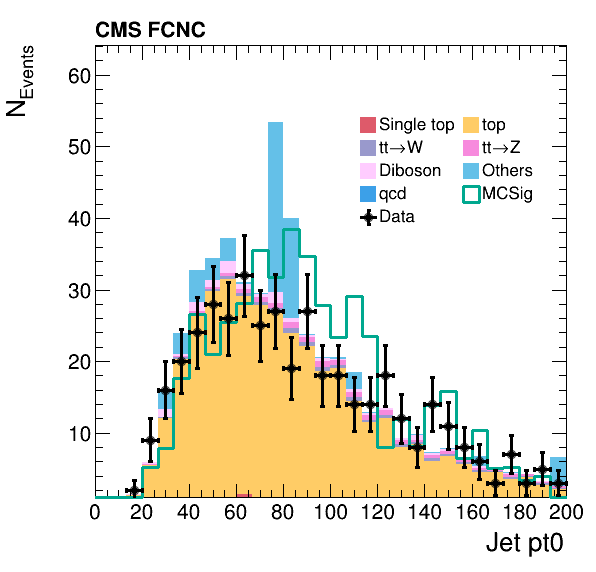

MET_pt_8_3.png



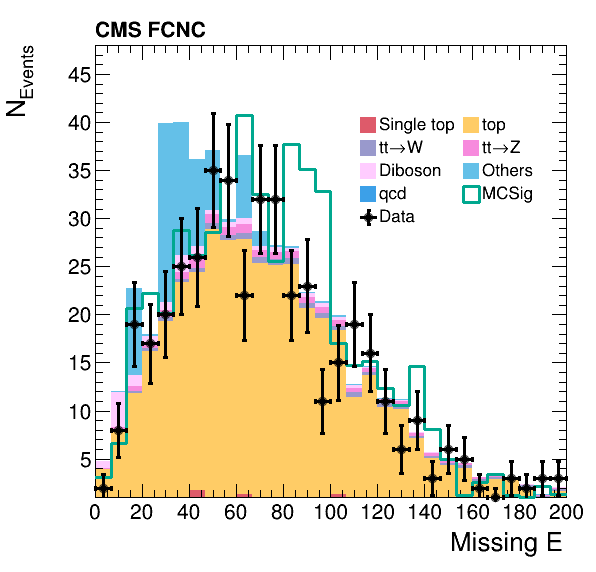

Muon_pt15_8_3.png



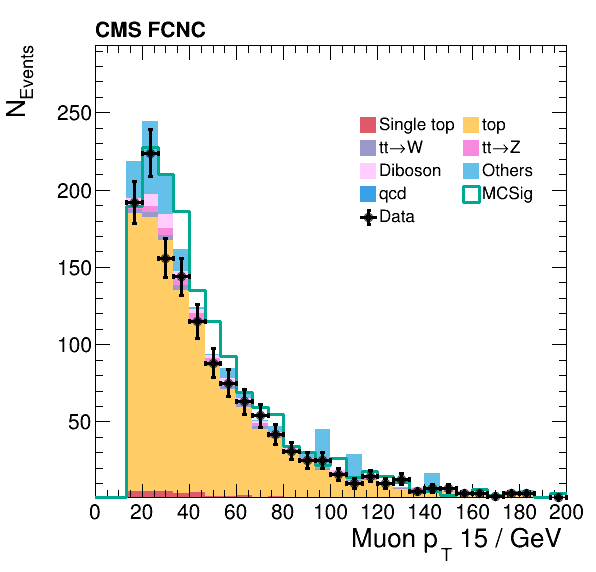

ST_8_3.png



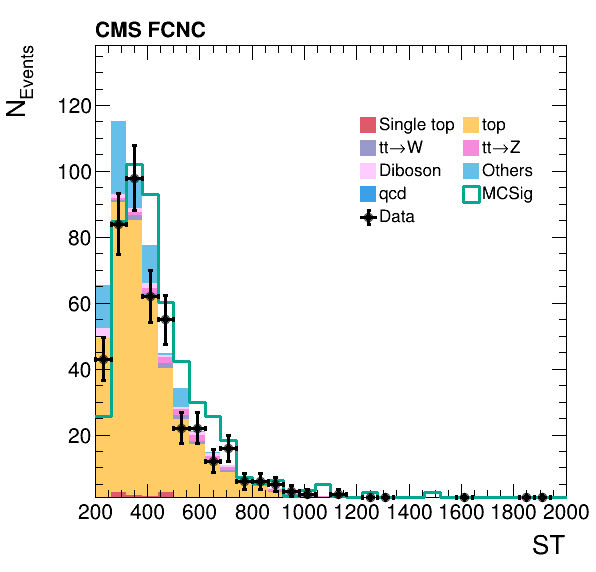

bJet_pt0_8_3.png



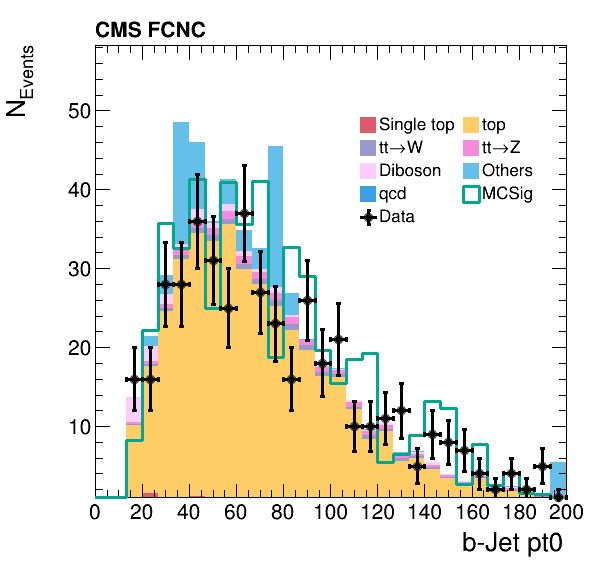

dPhi0_8_3.png



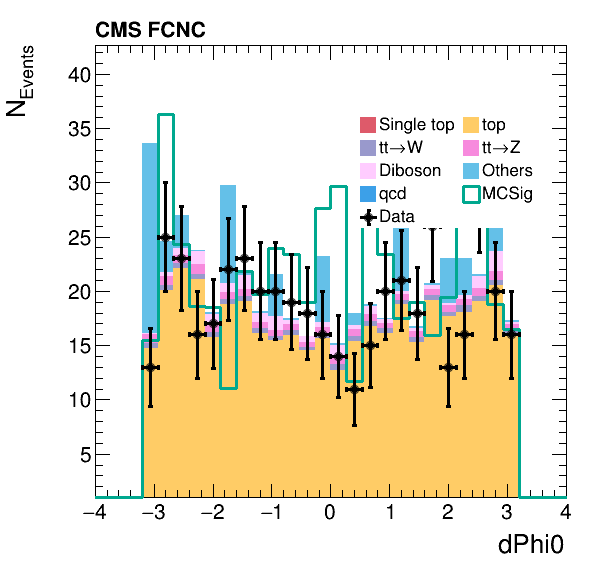

dPhi1_8_3.png



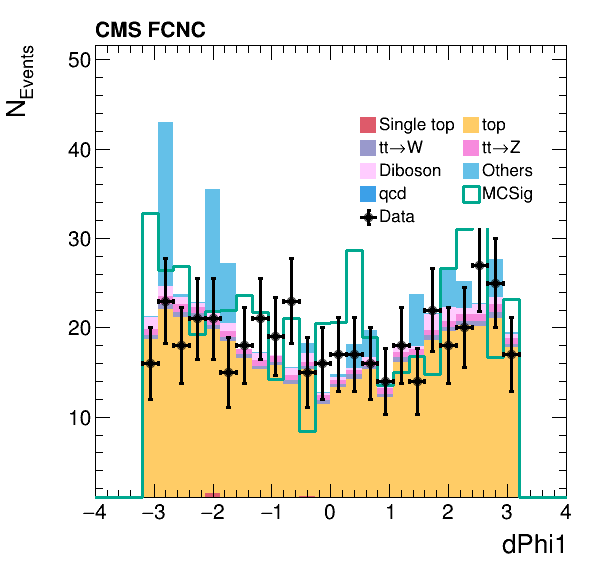

dPhi2_8_3.png



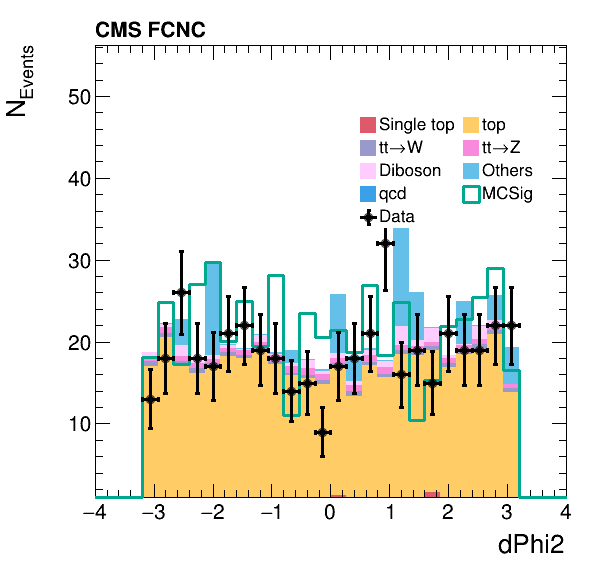

dR01_8_3.png



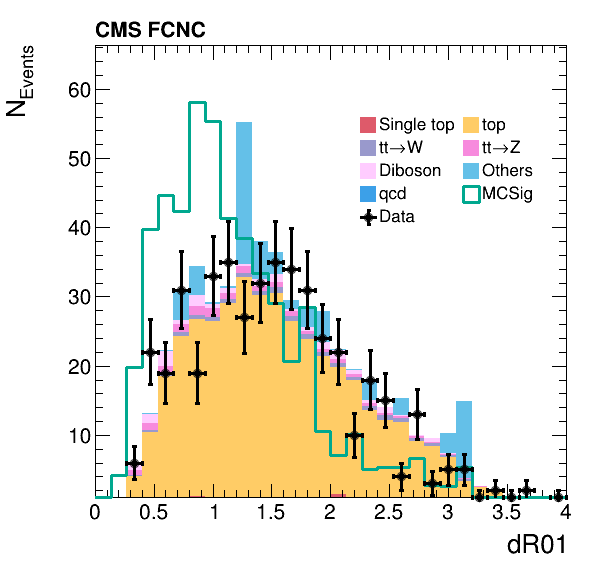

dR02_8_3.png



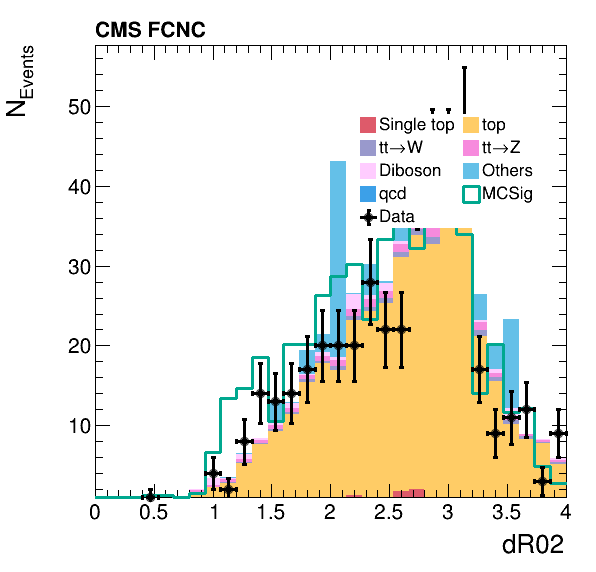

inv_m01_8_3.png



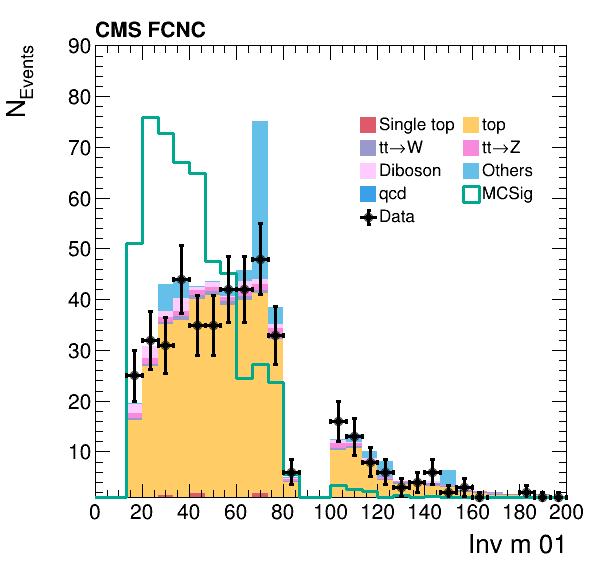

inv_m02_8_3.png



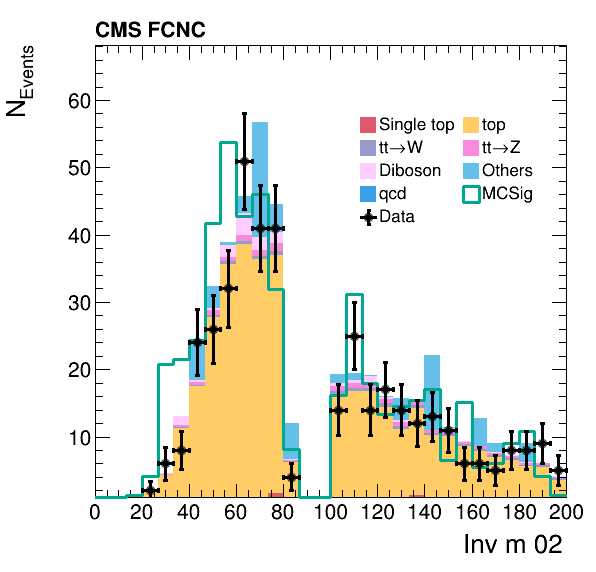

inv_m12_8_3.png



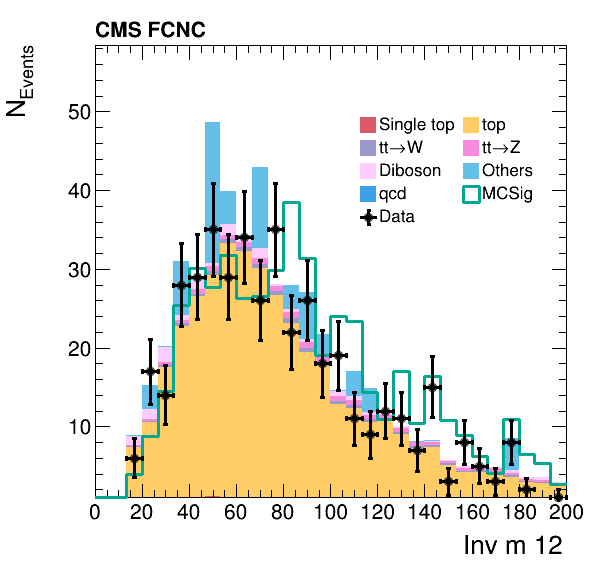

inv_m3_8_3.png



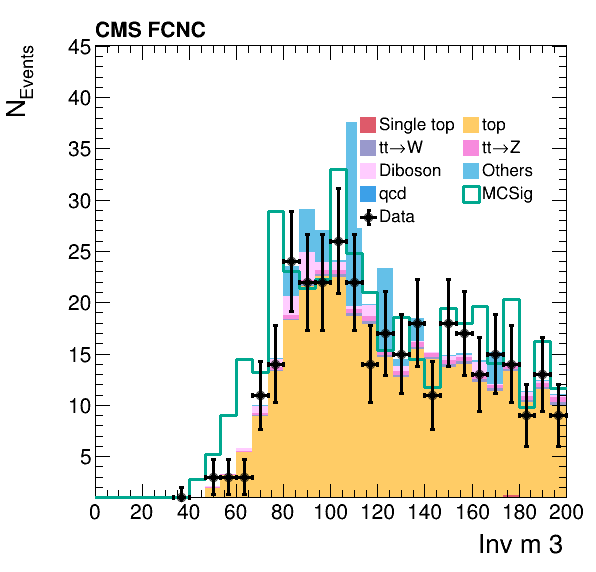

mu_pt0_8_3.png



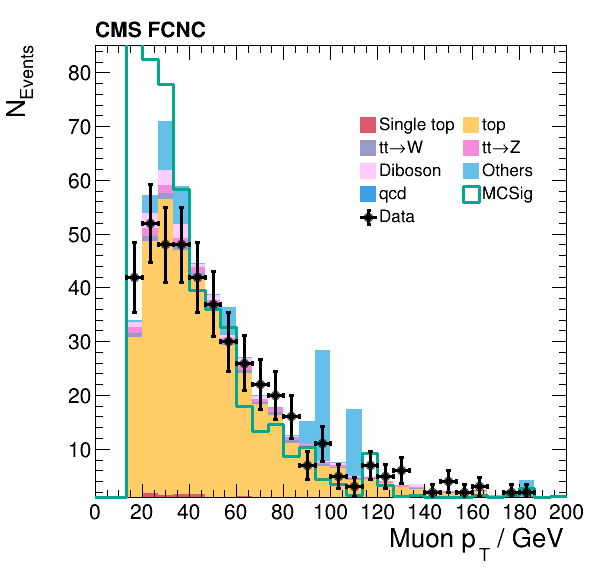

In [9]:
# ROOT.gROOT.GetListOfCanvases().Draw()
from IPython.display import Image
for image in sorted(os.listdir(dirPlotPath + 'Trials/')):
    if image.endswith('8_3.png'):
        print(image + '\n')
        display(Image(filename=(dirPlotPath + 'Trials/' + image)))

In [10]:
nSkim = 3
variable = 'inv_m01'

def signif(nSkim, title, variable=variable):    
    tfile = ROOT.TFile(dirPlotPath + 'Trials/8_{}.root'.format(nSkim), 'READ')

    MCSig = getHistogram(tfile, 'MCSig', variable)
    
    stack = ROOT.THStack('', '')
    seen, count, areaBkg = [], 0, 0
    titles = ['Single top', 'top', 'tt#rightarrowW', 'tt#rightarrowZ','Diboson', 'Others']
    for key in dfMCBkg.keys():
        histo = getHistogram(tfile, key, variable)
        areaBkg += histo.Integral('width')
        
    areaSig = MCSig.Integral('width')
    significance = round(areaSig/np.sqrt(areaBkg),3)
    
    with open('signif.txt', 'a') as f:
        f.write('\niSkim' + str(nSkim) + '\t' + title + '\t' + str(significance))
        f.close()

In [11]:
signif(3, '[inv_m01][newSignif] Jet_btagDeepB > 0.6, dimuon inv mass > 15, w cut')

***
### Examples and trials

### Histogram example

In [ ]:
fltr = ff.DeclareVariables[3](dfData, '', save=False)
histo = fltr.Histo1D(rr.RDF.TH1DModel('di_Jet_invm', 'di_Jet_invm', 30, 0, 200), 'di_Jet_invm')
#histo = fltr.Histo1D(rr.RDF.TH1DModel('inv_m01', 'inv_m01', 30, 0, 200), 'inv_m01')
c = ROOT.TCanvas('Hist','',800,600);
c.cd();
histo.Draw('hist');
c.Draw();

<!-- #### To clarify: -->
<!-- - sempre iSkim 2 (tagliare più duro: alzare taglio pt muon o isolamento) -->
<!-- - far vedere i tagli (soprattutto sui Jet, colonnina Other) -->
<!-- - fattore di scala per gli histos -->

#### To do:
**ANTIPASTI**
- plottare distanza dR tra leptoni (basta aggiungerla alla macro) - DONE
- scrivere una dizionario di dizionari per le variabili - DONE
- cambiare m_eff in ST - DONE
- errore sul MC

**MAIN COURSE**
- calcolare la significanza del segnale $S/\sqrt{B}$; se il taglio è buono il rapporto migliora - DONE (ci mette tanto)
- taglio più duro per i b-Jet (0.8-0.85)
- massa invariante tra Jet non b-taggati (bump per W~80GeV) -> eventualmente tagliare
- plot rapido della massa invariante leptoni opposite sign (bump per Z~91GeV) -> eventualmente tagliare - DONE
- questione same sign
- rimettere in ordine le filter function

**DESSERT**
- analisi statistica (con un BDT?)

**AMMAZZACAFFÈ**
- eventualmente togliere la QCD
- sempre iSkim 2

<!-- #### Prossimamente: -->
<!-- - BDT: discriminazione segnale/bkg (??) -->
<!-- - Esame MAPD -->